In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from datetime import datetime, timedelta

from xscale import signal
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:107: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/numba/core/errors.py:149: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


### Load datasets

In [2]:
ecco = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

In [3]:
budgFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_anom_fw.nc').budg_fw
budgH = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_anom_heat.nc').budgH

### Integrate anomalies

In [4]:
budgFw_int = (budgFw.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
budgH_int = (budgH.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')

In [5]:
budgFw_anom = budgFw_int - budgFw_int.mean('time')
budgH_anom = budgH_int - budgH_int.mean('time')

### Plot

In [6]:
class OffsetYearLocator(dates.YearLocator):
    def __init__(self, *args, **kwargs):
        self.offset = kwargs.pop("offset", 0)
        dates.YearLocator.__init__(self,*args, **kwargs)
    def tick_values(self, vmin, vmax):
        ymin = self.base.le(vmin.year) * self.base.step - self.offset
        ymax = self.base.ge(vmax.year) * self.base.step + (self.base.step-self.offset)
        ticks = [vmin.replace(year=ymin, **self.replaced)]
        while True:
            dt = ticks[-1]
            if dt.year >= ymax:
                return dates.date2num(ticks)
            year = dt.year + self.base.step
            ticks.append(dt.replace(year=year, **self.replaced))

def format_xaxis(ax):

    years = dates.YearLocator(10,month=1,day=1)
    years1=OffsetYearLocator(2,month=1,day=1, offset=1)
    dfmt = dates.DateFormatter('%Y')
    dfmt1 = dates.DateFormatter('%y')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(years1)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_formatter(dfmt1)
    ax.get_xaxis().set_tick_params(which='major', pad=15)

    plt.setp(ax.get_xmajorticklabels(), rotation=0, weight="bold", ha="center")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


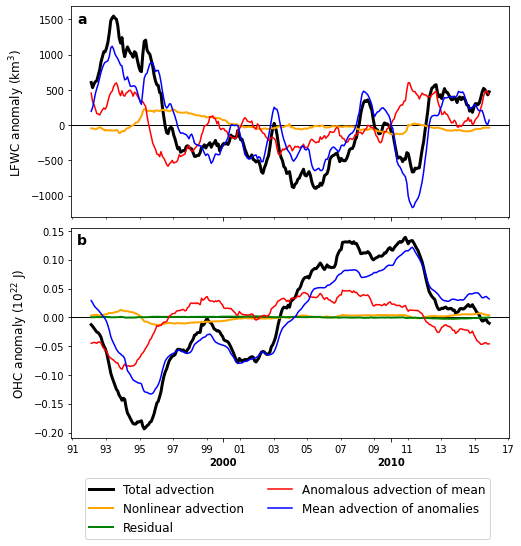

In [8]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_ConvFw')*1e-3, 
            lw=3, color='black',label='Total advection')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_Uanom_FWanom')*1e-3, 
            lw=2, color='orange',label='Nonlinear advection')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_Uanom_FWclim')*1e-3, 
            lw=1.5, color='red',label='Anomalous advection of mean')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_Uclim_FWanom')*1e-3, 
            lw=1.5, color='blue',label='Mean advection of anomalies')
axs[0].set_ylabel(r'LFWC anomaly (km$^3$)',fontsize=12)
axs[0].text(0.013,0.92, 'a', fontsize=14, fontweight='bold', transform=axs[0].transAxes)

axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='adv_ConvH')*1e-22, 
            lw=3, color='black',label='Total advection')
axs[1].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='adv_Uanom_Tanom')*1e-22, 
            lw=2, color='orange',label='Nonlinear advection')
axs[1].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='resH')*1e-22, 
            lw=2, color='green',label='Residual')
axs[1].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='adv_Uanom_Tclim')*1e-22, 
            lw=1.5, color='red',label='Anomalous advection of mean')
axs[1].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='adv_Uclim_Tanom')*1e-22, 
            lw=1.5, color='blue',label='Mean advection of anomalies')
axs[1].set_ylabel(r'OHC anomaly (10$^{22}$ J)', fontsize=12)
axs[1].text(0.013,0.92, 'b', fontsize=14, fontweight='bold', transform=axs[1].transAxes)
axs[1].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.97, -0.16), ncol=2, fontsize=12)

format_xaxis(axs[1])
fig.subplots_adjust(left=0.17, right=0.93, bottom=0.2, top=0.95, hspace=0.05, wspace=0.12)

#plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()